<a href="https://colab.research.google.com/github/Ran147/Project_T/blob/Eliab/FR_face_recognition__estudiantes_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: [Johan Rodríguez](https://github.com/Johanx22x)

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [ ]:
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
!pip install pytz
import datetime
import pytz

# Utils

## In-memory data

In [6]:
registered_faces = {}
registered_professor = []
registered_student = []
registered_miscelaneous = []
registered_class = []
registered_course = []
registered_attendance = []

##Save info

In [46]:
local_tz = pytz.timezone('America/Costa_Rica')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## face recognition

In [7]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## Real time streaming

In [36]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [37]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register Faces

In [ ]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)

In [ ]:
print(registered_faces)

## Informacion de profesores

In [75]:
def profesor():
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  print("")
  nationality = input("Nationality: ")
  print("")
  phonebook = {}
  # Start a loop to input phone numbers
  while True:
    # Ask the user for a contact name
    name = input("Enter contact name: ")
    # Ask the user for a phone number
    print("")
    phone_number = input("Enter phone number: ")
    # Add the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Ask the user if they want to add another phone number
    print("")
    another = input("Do you want to add another phone number? (yes/no): ")

    # Check if the user wants to stop
    if another != 'yes':
        break
  print("")
  email_list = []
  while True:
    email = input("Enter an email address: ")
    email_list.append(email)
    print("")
    another_email = input("Do you want to add another email? (yes/no): ")
    if another_email != "yes":
      break
  print("")
  address = input("Address: ")
  print("")
  specialty = input("Specialty: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  bloodtype = input("Blood type?: ")
  print("")
  teacher = {'name': registered_name, 'id': id, 'Birthday': birthday,
            'nationality': nationality, 'Phone book': phonebook,
            'emails': email_list, 'address': address, 'specialty': specialty,
            'matiral status': marital_status, 'blood Type': bloodtype}
  registered_professor.append(teacher)

## Informacion de estudiantes

In [74]:
def estudiante():
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  print("")
  nationality = input("Nationality: ")
  print("")
  phonebook = {}
  # Start a loop to input phone numbers
  while True:
    # Ask the user for a contact name
    name = input("Enter contact name: ")
    print("")
    # Ask the user for a phone number
    phone_number = input("Enter phone number: ")
    print("")
    # Add the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Ask the user if they want to add another phone number
    another = input("Do you want to add another phone number? (yes/no): ")

    # Check if the user wants to stop
    if another != 'yes':
        break
  print("")
  email_list = []
  while True:
    email = input("Enter an email address: ")
    email_list.append(email)
    print("")
    another_email = input("Do you want to add another email? (yes/no): ")
    if another_email != "yes":
      break
  print("")
  address = input("Adress")
  print("")
  carreer = input("Carreer: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  bloodtype = input("Blood type?: ")
  print("")
  student = {'name': registered_name, 'id': id, 'Birthday': birthday,
            'nationality': nationality, 'Phone book': phonebook,
            'emails': email_list, 'address': address, 'carreer': carreer,
            'matiral status': marital_status, 'blood Type': bloodtype}
  registered_student.append(student)

## Informacion de miscelaneos

In [73]:
def miscelaneous():
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  print("")
  nationality = input("Nationality: ")
  print("")
  phonebook = {}
  # Start a loop to input phone numbers
  while True:
    # Ask the user for a contact name
    name = input("Enter contact name: ")
    print("")
    # Ask the user for a phone number
    phone_number = input("Enter phone number: ")
    print("")
    # Add the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Ask the user if they want to add another phone number
    another = input("Do you want to add another phone number? (yes/no): ")
    print("")
    # Check if the user wants to stop
    if another != 'yes':
        break
  print("")
  email_list = []
  while True:
    email = input("Enter an email address: ")
    print("")
    email_list.append(email)
    another_email = input("Do you want to add another email? (yes/no): ")
    print("")
    if another_email != "yes":
      break
  address = input("Adress")
  print("")
  schedule = input("Schedule: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  bloodtype = input("Blood type?: ")
  print("")
  xperson = {'name': registered_name, 'id': id, 'Birthday': birthday,
            'nationality': nationality, 'Phone book': phonebook,
            'emails': email_list, 'address': address, 'schedule': schedule,
            'matiral status': marital_status, 'blood Type': bloodtype}
  registered_miscelaneous.append(xperson)

## Informacion de aulas

In [72]:
def classroom(registered_miscelaneous):
  classnum = input("Write the number of the class: ")
  print("")
  misceasignado = input("Write the name of the miscelaneous in charge: ")
  print("")
  for i in registered_miscelaneous:
    if misceasignado not in i:
      print("The miscelaneous doesn't exist")
    else:
      aula = {'name': misceasignado, 'clase': classnum}
      registered_class.append(aula)

## Informacion de cursos

In [71]:
def course(registered_student, registered_professor, registered_class):
  code = input("Write the code of the course: ")
  print("")
  coursename = input("Write the name of the course: ")
  print("")
  period = input("Write the period of the course: ")
  print("")
  career = input("Write the career to which the course belongs: ")
  print("")
  students_list = []
  teachers_list = []
  schedule_list = []
  classroom_list = []
  while True:
    students_in = input("Write the enrolled students: ")
    print("")
    if students_in not in registered_student:
        print("This student is not register")
    else:
      students_list.append(students_in)
      another_student = input("Do you want to add another student? (yes/no): ")
      if another_student != "yes":
        break
  while True:
    print("")
    teachers_in = input("Write the assigned teacher: ")
    print("")
    if teachers_in not in registered_professor:
      print("This teacher is not register")
    else:
      teachers_list.append(teachers_in)
      another_teacher = input("Do you want to add another teacher? (yes/no): ")
      if another_teacher != "yes":
        break
  while True:
    print("")
    schedule = input("Enter the day of the course: ")
    schedule_list.append(schedule)
    print("")
    another_schedule = input("Do you want to add another day? (yes/no): ")
    print("")
    if another_schedule != "yes":
      break
  while True:
    classroom_in = input("Write the assigned classroom: ")
    print("")
    if classroom_in not in registered_class:
      print("This classroom doesn't exist")
    else:
      classroom_list.append(classroom_in)
      another_teacher = input("Do you want to add another teacher? (yes/no): ")
      print("")
      if another_teacher != "yes":
        break
  course_info = {'Code of the course: ', code, 'Name of the course: ', coursename,
                 'Period of the course: ', period, 'Career to which the course belongs: ',
                 career, 'List of students in this course: ', students_list,
                 'List of teachers in this course: ', teachers_list,
                 'Schedule of this course: ', schedule_list,
                 'Classroom of this course: ', classroom_list}
  registered_course.append(course_info)

# Recognize Faces

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''
i = 0

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])
  img_path = '/content/drive/MyDrive/Imagenes_Taller/' + 'img'+str(i) + '.jpg'
  cv2.imwrite(img_path, img)


   # Get the current time
  current_time = datetime.datetime.now(local_tz).strftime("%Y-%m-%d %H:%M:%S")

    # Draw the current time on the frame
  cv2.putText(
        img,
        current_time,
        (10, 30),  # Position to display the time (you can adjust this)
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,  # Font scale
        (0, 0, 0),  # Text color (white)
        2,  # Thickness of the text
        cv2.LINE_AA,
    )

  # Get the face locations from the frame
  face_locations = face_recognition.face_locations(img)

  # For each face in the frame
  for (top, right, bottom, left) in face_locations:
      # Draw a rectangle around the face
      cv2.rectangle(
          img,
          (left, top),
          (right, bottom),
          (0, 0, 255),
          2,
      )
      # Get the face encoding of the face
      face_encoding = face_recognition.face_encodings(img, [(top, right, bottom, left)])[0]

      # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

      # If there is a match
      if True in matches:
          # Get the index of the match
          match_index = matches.index(True)

          # Get the name of the match
          ate = []
          match_name = list(registered_faces.keys())[match_index]
          ate.append(match_name)
          ate.append(img_path)
          ate.append(current_time)
          registered_attendance.append(ate)


          # Draw the name of the match on the frame
          cv2.putText(
              img,
              match_name,
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )
      else:
          # Draw unknown on the frame
          cv2.putText(
              img,
              "Unknown",
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )

  # Show image
  plt.imshow(img)
  plt.show()
  i += 1

##Reporte de asistencia

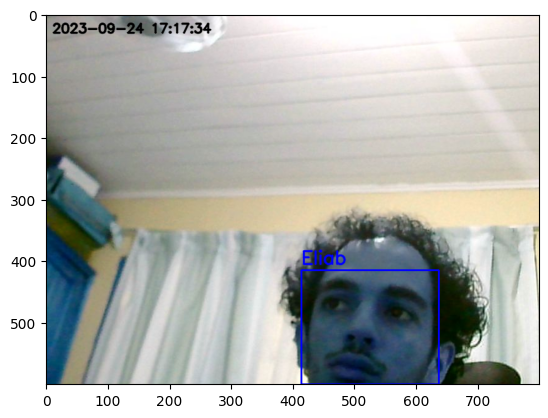

In [54]:
plt.imshow(img)
plt.show()

##Consultas

In [25]:
def print_teachers(registered_professor):
  print(registered_professor)

def print_students(registered_student):
  print(registered_student)

def print_miscelaneos(registered_miscelaneous):
  print(registered_miscelaneous)

def print_classroom(registered_class):
  print(registered_class)

def print_courses(registered_course):
  print(registered_course)




def find_name(name, dictionary_list):
    found_entries = []
    for entry in dictionary_list:
        if 'name' in entry and entry['name'] == name:
            found_entries.append(entry)
    if len(found_entries) >= 1:
      return True

## Ejecutar codigo

In [70]:
print("-------------Welcome to our Classroom Assistant program with People Recognition-------------")
print("")
print("Additional information about:", registered_name)
print("")
print("What rol does", registered_name,"have within the organization?")
print("")
while True:
  rol = int(input("Professor (1), Student (2) or Miscelanous (3)? Make your choice  "))
  print("")

  if rol == 1:
    print("-------------------Section of teachers---------------------")
    print("")
    profesor()
    print("-----------------------------------------------------------")

  elif rol == 2:
    print("-------------------Section of students---------------------")
    print("")
    estudiante()
    print("-----------------------------------------------------------")

  else:
    print("-------------------Section of miscellaneous----------------")
    print("")
    miscelaneous()
    print("-----------------------------------------------------------")

  print("")
  another_info = input("Do you want to add more information? (yes/no): ")
  print("")
  if another_info != 'yes':
    break

print("Now, provide us with the information of your classrooms and courses")
print("")

while True:
  rol1 = int(input("Classroom (1) or Course (2)? Make your choice  "))
  print("")

  if rol == 1:
    print("-------------------Section of classrooms---------------------")
    print("")
    classroom(registered_miscelaneous)
    print("-----------------------------------------------------------")

  else:
    print("-------------------Section of courses---------------------")
    print("")
    course(registered_student, registered_professor, registered_class)
    print("-----------------------------------------------------------")

  print("")
  another_info = input("Do you want to add more information? (yes/no): ")
  print("")
  if another_info != 'yes':
    break

print("Now you will be able to see all of the consultation available")
print("---------------------------------------------------------")
print("(1).Show teachers")
print("(2).Show students")
print("(3).Show miscellaneous")
print("(4).Show classrooms")
print("(5).Show courses")
print("(6).Show attendance")
print("(7).Show students in courses ascendingly")
print("(8).Show students in courses descendingly")
print("(9).Show student with highest attendance")
print("(10).Show student with the least attendance")
print("(11).Show course with the day with the most attendance")
print("(12).")
print("---------------------------------------------------------")

while True:
  print("")
  consultation = int(input("Make your choice:  "))
  print("")

  if consultation == 1:
    print("-------------------Show teachers---------------------")
    print("")
    print_teachers(registered_professor)
    print("-----------------------------------------------------------")

  elif consultation == 2:
    print("-------------------Show students---------------------")
    print("")
    print_students(registered_student)
    print("-----------------------------------------------------------")

  elif consultation == 3:
    print("-------------------Show miscellaneous---------------------")
    print("")
    print_miscelaneos(registered_miscelaneous)
    print("-----------------------------------------------------------")

  elif consultation == 4:
    print("-------------------Show classrooms---------------------")
    print("")
    classroom(registered_miscelaneous)
    print("-----------------------------------------------------------")

  elif consultation == 5:
    print("-------------------Show courses---------------------")
    print("")
    print_courses(registered_course)
    print("-----------------------------------------------------------")

  elif consultation == 6:
    print("-------------------Show attendance---------------------")
    print("")
    course(registered_student, registered_professor, registered_class)
    print("-----------------------------------------------------------")

  elif consultation == 7:
    print("-------------------Show teachers---------------------")
    print("")
    classroom(registered_miscelaneous)
    print("-----------------------------------------------------------")

  elif consultation == 8:
    print("-------------------Show students---------------------")
    print("")
    course(registered_student, registered_professor, registered_class)
    print("-----------------------------------------------------------")

  elif consultation == 9:
    print("-------------------Show teachers---------------------")
    print("")
    classroom(registered_miscelaneous)
    print("-----------------------------------------------------------")

  elif consultation == 10:
    print("-------------------Show students---------------------")
    print("")
    course(registered_student, registered_professor, registered_class)
    print("-----------------------------------------------------------")

  elif consultation == 11:
    print("-------------------Show teachers---------------------")
    print("")
    classroom(registered_miscelaneous)
    print("-----------------------------------------------------------")

  else:
    print("-------------------Show students---------------------")
    print("")
    course(registered_student, registered_professor, registered_class)
    print("-----------------------------------------------------------")

  print("")
  another_info = input("Do you want to add more information? (yes/no): ")
  print("")
  if another_info != 'yes':
    break


classroom(registered_miscelaneous)
print("Now you can choose the consultations you want us to show you")
print("Choose one of the following options")

-------------Welcome to our Classroom Assistant program with People Recognition-------------

Additional information about: None

What rol does None have within the organization?

Professor (1), Student (2) or Miscelanous (3)? Make your choice  1

-------------------Section of teachers---------------------

Enter the identification: 5

Birthday: 4

Nationality: 3

Enter contact name: 4

Enter phone number: 5

Do you want to add another phone number? (yes/no): 1

Enter an email address: 3

Do you want to add another email? (yes/no): 4

Address: 

Specialty: 3

Marital status: 4

Blood type?5

-----------------------------------------------------------



KeyboardInterrupt: ignored

In [ ]:
for person in registered_professor:
  print(person)
  name = person['name']
  if match_name == name:
    id = person['id']
    print(id)

{'name': 'Eliab', 'id': '1233421', 'Birthday': '12'}
{'name': 'Randy', 'id': '504470682', 'Birthday': '25-2-2003'}
504470682
